# Simple Example



Consider the cantilever beam loaded by two concentrated forces. The variables are uncorrelated and their properties are summarized as

| $X$         | $\mu_{X} $       | $\sigma_{X} $ |
|-------------|-----------------------|--------------------|
| $F_{m} $ | 167 MPa               | 20 MPa             |
| $W_{y} $ | 1.5e6 mm$^{3}$ | 0                  |
| $l$         | 4 m                   | 0                  |
| $P_{1} $ | 10 kN                 | 3 kN               |
| $P_{2} $ | 10 kN                 | 3 kN               |

Formulate the safety margin based on the cross-section capacity ultimate limit state, i.e. the beam fails if the moment capacity is exceeded. Write the second moment representation of $F_m$, $P_1$ and $P_2$ and calculate the reliability index.


## Solution


The linear safety margin is $M=W_{y}F_{m}-lP_{1}-2lP_{2}$. 
The second moment representation of the set of basic variables ${\textbf{X}}=\left({F}_{m} ,P_{1} ,P_{2} \right)$ is:

$E\left[{\textbf{X}}\right]=\left[\begin{array}{c} {167~\text{MPa}} \\ {10000~\text{N}} \\ {10000~\text{N}} \end{array}\right]; \quad {\textbf{C}}_{{\textbf{X}}} =\left[\begin{array}{ccc} {20^{2}~\left(\text{MPa}\right)^{2} } & {0} & {0} \\ {0} & {3000^{2}~\text{N}^{2} } & {0} \\ {0} & {0} & 3000~{\text{N}^{2} } \end{array}\right]$

$a_{0} =0$ and the vector of the coefficients is:

${\textbf{a}}^{\text{T}} =\left[\begin{array}{ccc} {W_{y} } & {-l} & {-2l} \end{array}\right]=\left[\begin{array}{ccc} {1.5\cdot 10^{6}~\text{mm}^{3} } & {-4000~\text{mm}} & {-8000~\text{mm}} \end{array}\right]$

The reliability index is calculated by means of $\beta_{C} =\dfrac{E\left[M\right]}{D\left[M\right]} =\dfrac{a_{0} +{\textbf{a}}^{T} E\left[{\textbf{X}}\right]}{\sqrt{{\textbf{a}}^{T} {\textbf{C}}_{{\textbf{X}}} {\textbf{a}}} }$ yielding $\beta_{C} =3.24$.

In [26]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats

fontsizes=18
plt.rcParams.update({'font.size': fontsizes})
plt.rcParams.update({"font.family": "serif"})
plt.rcParams.update({"mathtext.fontset" : "cm"})
plt.rcParams.update({'font.serif': 'Times New Roman'})
plt.close('all')


In [28]:
#==============================================================================
# INPUT
#==============================================================================
# Geometry 
l = 4e3                                 # [mm] 
W = 1.5e6                               # [mm^3] 

# Material resistance
mu_Fm = 167                             # [N/mm^2]      
sigma_Fm = 20                           # [N/mm^2]    

# Loads
mu_P1 = 10e3                            # [N]    
sigma_P1 = 3e3                          # [N]  

mu_P2 = 10e3                            # [N]    
sigma_P2 = 3e3                          # [N]  

#==============================================================================

# Vectors
E = np.array([mu_Fm, mu_P1, mu_P2])
a = np.array([W, -l, -2*l])
at = np.transpose(a)
Cx = np.array([[sigma_Fm**2, 0, 0],
                   [0, sigma_P1**2, 0],
                   [0, 0, sigma_P2**2]])

In [29]:
#==============================================================================
# BETA
beta=np.dot(at,E)/np.sqrt(np.dot(np.dot(at,Cx),a))
print("Reliability index beta for uncorrelated variables {b:.2f}\n".format(b=float(beta)))

Reliability index beta for uncorrelated variables 3.24



Now, we can assess the effect of correlation on the reliability index. Assume, for example, that $P_1$ and $P_2$ are correlated and the correlation coefficient is $\rho=0.8$. 

In [30]:
rho=0.8
Cx08 = np.array([[sigma_Fm**2, 0, 0],
                   [0, sigma_P1**2, sigma_P1*sigma_P2*rho],
                   [0, sigma_P1*sigma_P2*rho, sigma_P2**2]])
beta_08=np.dot(at,E)/np.sqrt(np.dot(np.dot(at,Cx08),a))
print("Reliability index beta for correlated variables {b:.2f}\n".format(b=float(beta_08)))

Reliability index beta for correlated variables 2.86



We can also perform a parameter study on how a correlation coefficient from -1 to +1 will effect the reliability index.

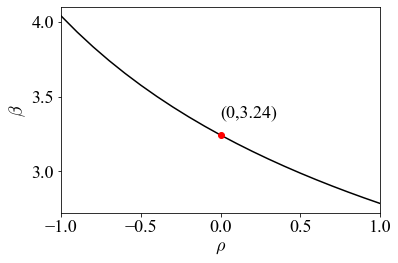

In [6]:
rhoV = np.arange(-1, 1+0.1, 0.1)
rhoV[np.abs(rhoV.real) < 1e-15] = 0.0
betalist = []
for rho in rhoV:
    Cx = np.array([[sigma_Fm**2, 0, 0],
                   [0, sigma_P1**2, sigma_P1*sigma_P2*rho],
                   [0, sigma_P1*sigma_P2*rho, sigma_P2**2]])
    betalist.append(np.dot(at,E)/np.sqrt(np.dot(np.dot(at,Cx),a)))

# Uncorrelated case
beta_rho0 =  np.array(betalist)[np.nonzero(rhoV==0.)[0]]                # Reliability index



# Plot
fig, ax = plt.subplots()
ax.plot(rhoV,betalist,'k')
ax.plot(0,beta_rho0,'or')
ax.text(0,beta_rho0,'({r:.0f},{b:.2f})\n'.format(r=0,b=float(beta_rho0)))
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\beta$')
ax.set_xlim(-1,1)
plt.tight_layout()
plt.show()


# Monte Carlo (getting started)


For the considered example the exact result can be computed by using the safety margin as illustrated above. Alternatively, we can use Monte Carlo Simulation and see how close we come to the correct result. The following steps are performed for the case of uncorrelated variables:

## 1. Generation of random realisations of the variables
The random variables of the problem are $F_m$, $P_1$ and $P_2$, and we generate $n$ random realisations. In order to generate a random realization of an arbitrarily distributed variable, the so called transverse method can be used. Basis is taken in the cumulative distribution $F_{X}(x)$ of the random variable $X$. The cumulative distribution is defined as the probability that a realization $x$ is smaller or equal than $X$ , i.e. $F_{X} (x)=\Pr (x\le X)=y$, where $y$ is defined in the interval $\left[0,1\right]$.

The idea of the transverse method is to generate a realization of a uniform distributed random variable $y$ and use the transposed cumulative distribution function of $X$ to generate a realization  $x$, i.e. $x=F_{X}^{-1}(y)$.


In [44]:
n_sim = int(1E7)                 # Number of simulations

f_m = sp.stats.norm.ppf(np.random.uniform(size=n_sim),loc=mu_Fm,scale=sigma_Fm)
p1 = sp.stats.norm.ppf(np.random.uniform(size=n_sim),loc=mu_P1,scale=sigma_P1)
p2 = sp.stats.norm.ppf(np.random.uniform(size=n_sim),loc=mu_P1,scale=sigma_P1)

In many circumstances it is more efficient to generate random realisations directly sampled from that distribution. 

In [45]:

f_m = np.random.normal(loc=mu_Fm, scale=sigma_Fm, size=n_sim)
p1 = np.random.normal(loc=mu_P1, scale=sigma_P1, size=n_sim)
p2 = np.random.normal(loc=mu_P2, scale=sigma_P2, size=n_sim)

## 2. Computation of the limit state function with this realisations

In [46]:
g=W*f_m-p1*l-p2*2*l

## 3. Count the number of failures, i.e. number of $g\leq0$, and calculate $P_F$ and $\beta$

In [47]:
# % Count the number of failures
fails = np.zeros(n_sim);
fails[np.nonzero(g<=0)[0]] = 1;
Pf = np.sum(fails)/n_sim
beta_mc = -sp.stats.norm.ppf(Pf)
print("Probability of failure = {pf:.2e}\n".format(pf=float(Pf)))
print("beta = {b:.2f}\n".format(b=float(beta_mc)))

Probability of failure = 6.10e-04

beta = 3.23



## Covergence
The results of a Monte Carlo simulation are getting more accurate with increasing number of simulations $n$. Actually, the results become exact for $n \rightarrow \infty$! Let's look at the convergence behavior, i.e. how the MC estimates converge to the correct  with increasing $n$. 

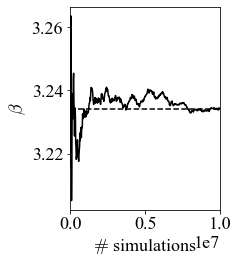

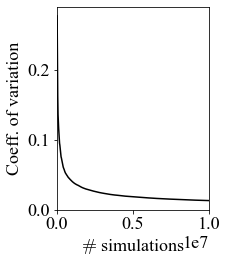

In [48]:
# Check convergence
m = int(n_sim/500)
t = 0
plt_range = np.arange(m-1,n_sim,m)
nn = np.zeros(len(plt_range))
Pf_plt = np.zeros(len(plt_range))
beta_plt = np.zeros(len(plt_range))
cov = np.zeros(len(plt_range))
for j in plt_range:
   nn[t] = j;
   Pf_plt[t] = np.mean(fails[0:j])
   beta_plt[t] = -sp.stats.norm.ppf(Pf_plt[t])
   cov[t] = 1 / Pf_plt[t] * np.sqrt((Pf_plt[t] - Pf_plt[t]**2)/j)
   t = t+1

plt.figure()
plt.subplot(121)
plt.plot(nn, beta_plt,'k')
plt.plot(np.array([0,n_sim]),np.array([beta_plt[t-1],beta_plt[t-1]]),'--k')
plt.ylabel(r'$\beta$')
plt.xlabel(r'$\#$ simulations')
plt.xlim(0,n_sim)
plt.tight_layout()
plt.show()
plt.subplot(122)
plt.plot(nn, cov,'k')
plt.ylabel('Coeff. of variation')
plt.xlabel(r'$\#$ simulations')
plt.xlim(0,n_sim)
plt.tight_layout()
plt.show()
